# Chat with your CSV documents!

The following notebook illustrates how you can use the Semantic Kernel to create
a basic chat experience over your CSV documents.

It primarily makes use of embeddings and the Semantic Kernel's concept of Memory. 

In [4]:
import semantic_kernel as sk
from semantic_kernel.ai.open_ai import OpenAITextCompletion, OpenAITextEmbedding

import pickle 
import pandas as pd
from IPython.display import clear_output

### Load your CSV 
The data included is a curated list of drawing tutorials for people wanting to learn how to draw
different animated characters, animals, and people. 

In [5]:
df = pd.read_csv("../data/art-tutorial-links.csv")

In [6]:
df.head()

,Difficulty,Link,Tags,Description
0,Easy,https://www.youtube.com/watch?v=WIbD1EQOi9c,"comic, Batman",The video provides step-by-step instructions o...
1,Easy,https://www.youtube.com/watch?v=7U8j9bjmM0E&t,"comic, Spiderman",The tutorial provides a step-by-step guide on ...
2,Easy,https://www.youtube.com/watch?v=g8THwvHRnsI,"comic, Spiderman",This YouTube video provides a step-by-step tut...
3,Easy,https://www.youtube.com/watch?v=g6OJH4VIgsA,"Food, boba",First thing we’re going to do is draw the cup....
4,Easy,https://www.youtube.com/watch?v=I-9UxsWEi2k,"Food, watermelon",The YouTuber guides the audience in how to dra...


### Setup the Semantic Kernel

In [7]:
def build_kernel() -> sk.Kernel:
    # Setup kernel with OpenAI completion and embedding backends
    api_key, org_id = sk.openai_settings_from_dot_env()

    kernel = (
        sk.kernel_builder()
        .configure(lambda c: c.add_text_backend("completion", OpenAITextCompletion("text-davinci-003", api_key, org_id)))
        .configure(lambda c: c.add_embedding_backend("embeddings", OpenAITextEmbedding("text-embedding-ada-002", api_key, org_id)))
        .with_memory_storage(sk.memory.VolatileMemoryStore())
        .build()
    )

    kernel.import_skill(sk.core_skills.TextMemorySkill())

    return kernel

In [8]:
kernel = build_kernel()

### Create embeddings using the appropriate columns in the CSV

In [11]:
# print("Adding rows of the CSV to VolatileMemory.");
# memory_collection_name = "csv-file"
# for idx, row in df.iterrows():
#     clear_output(wait=True)
#     await kernel.memory.save_reference_async(
#         collection=memory_collection_name,
#         description=row['Description'],
#         text=str(row['Description']+ " | " + row['Difficulty']),
#         external_id=row["Link"],
#         external_source_name=memory_collection_name
#     )
#     print("Row {} saved".format(idx))

### Persist kernel memory using pickle

In [12]:
# temp = kernel.memory._storage._store
# with open("kernel_memory_storage_store.pkl", "wb") as f:
#     pickle.dump(kernel.memory._storage._store, f)

with open("kernel_memory_storage_store.pkl", "rb") as f:
    kernel.memory._storage._store = pickle.load(f)

In [13]:
# print("Begin chatting (type 'exit' to exit):\n")
# chatting = True
# while chatting:
#     chatting = await chat(kernel, chat_func, context)

### Chat to get the best Youtube link!

In [14]:
memory_collection_name = "csv-file"

In [21]:
# ask = "I love Batman! I want an easy tutorial for how to draw him!"
#ask = "I want to learn how to draw animals for beginners"
ask = "I want to learn how to draw comic book characters"
print("===========================\n" + "Query: " + ask + "\n")

memories = await kernel.memory.search_async(memory_collection_name, ask, limit=5, min_relevance_score=0.77)

for i, memory in enumerate(memories):
    print("Result {}".format(i+1))
    print("  URL:     : " + memory.id)
    print("  Description    : " + memory.description)
    print("  Relevance: " + str(memory.relevance))
    print()
    

Query: I want to learn how to draw comic book characters

Result 1
  URL:     : https://www.youtube.com/watch?v=WIbD1EQOi9c
  Description    : The video provides step-by-step instructions on how to draw a comic book-style Batman. The artist begins by drawing the upper brow, eyes, nose, mouth, and chin, and then adds details to the head and body, including the ears, cheeks, belt, and bat symbol. Later on, the artist works on the legs, feet, hip, arms, and adds final details to the cape, spikes, and gloves. The tutorial is clear and easy to follow, making it a great guide for anyone looking to draw Batman.
  Relevance: 0.8601755250468365

Result 2
  URL:     : https://www.youtube.com/watch?v=89gPKm1JUeI
  Description    : Welcome to the best Online Education Program for artists. Learn how to draw with Cartooning Club How To Draw. I'll teach you the simple method of drawing using easy to follow step by step instructions. If you're looking for some easy to follow homeschool programs or art

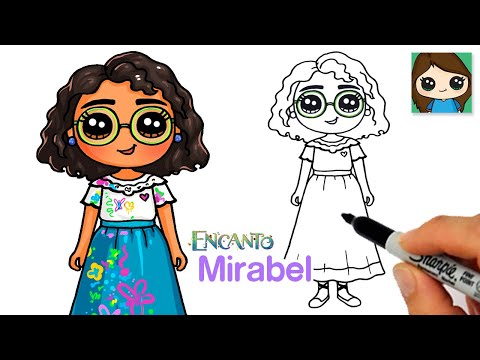

In [19]:
from IPython.display import YouTubeVideo

YouTubeVideo(memory.id.split("?v=")[1], width=800, height=600)